In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
h.load_file('stdrun.hoc')


1.0

In [2]:

# --- Model ---
soma = h.Section(name='soma')
soma.L = soma.diam = 20  # µm
soma.Ra = 100
soma.cm = 1.0
soma.insert('pas')
soma.e_pas = -65
soma.g_pas = 1e-4
soma.insert('hh')

# --- Stimulus (shared timing) ---
stim = h.IClamp(soma(0.5))
stim.delay = 5.0   # ms
stim.dur   = 1.0   # ms

tstop = 40.0
v_init = -65.0

In [3]:
                    # record default gbar values for hh (to scale from)
                    # attribute names for built-in hh are gnabar_hh and gkbar_hh
                    base_gna = getattr(soma(0.5), 'gnabar_hh', None)
                    base_gk  = getattr(soma(0.5), 'gkbar_hh', None)

                    # restore base conductances or use this to set to another value
                    soma(0.5).gnabar_hh = base_gna
                    soma(0.5).gkbar_hh  = base_gk


In [4]:

# --- Parameters to compare ---
amp1 = 0.05  # nA
amp2 = 0.1  # nA
spike_v_threshold = 0.0  # mV for spike detection

def run_trial(amp):
    stim.amp = amp
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(soma(0.5)._ref_v)
    h.finitialize(v_init)
    h.continuerun(tstop)
    t = np.array(tvec); v = np.array(vvec)
    spiked = v.max() > spike_v_threshold
    peak_v = v.max()
    spike_time = None
    if spiked:
        idx = np.where(v > spike_v_threshold)[0][0]
        spike_time = t[idx]
        latency = spike_time - stim.delay
    else:
        latency = None
    return {'amp': amp, 't': t, 'v': v, 'spiked': spiked, 'peak_v': peak_v, 'latency': latency}

In [5]:

r1 = run_trial(amp1)
r2 = run_trial(amp2)


In [6]:

# --- Print simple summary ---
def print_summary(r):
    print(f"Amp = {r['amp']:.3f} nA: peak V = {r['peak_v']:.2f} mV; spiked = {r['spiked']}", end='')
    if r['spiked']:
        print(f"; latency = {r['latency']:.2f} ms after stimulus onset")
    else:
        print()

print_summary(r1)
print_summary(r2)

Amp = 0.050 nA: peak V = -61.82 mV; spiked = False
Amp = 0.100 nA: peak V = 33.84 mV; spiked = True; latency = 4.85 ms after stimulus onset


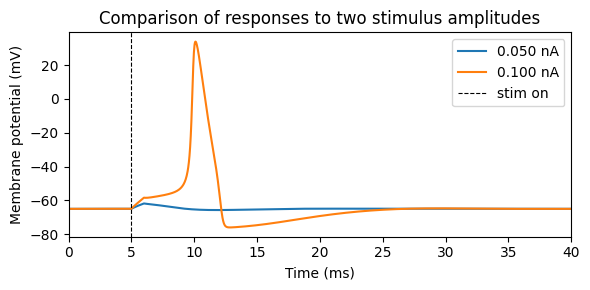

In [7]:


# --- Plot overlay ---
plt.figure(figsize=(6,3))
plt.plot(r1['t'], r1['v'], label=f"{r1['amp']:.3f} nA", color='C0', lw=1.5)
plt.plot(r2['t'], r2['v'], label=f"{r2['amp']:.3f} nA", color='C1', lw=1.5)
plt.axvline(stim.delay, color='k', ls='--', lw=0.8, label='stim on')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Comparison of responses to two stimulus amplitudes')
plt.legend(loc='upper right')
plt.xlim(0, tstop)
plt.tight_layout()
plt.show()